In [21]:
# Imports basics
import numpy as np
import h5py
import json
import setGPU
import sklearn
import corner
import os
import scipy
# Imports neural net tools
import itertools
import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim
from fast_soft_sort.pytorch_ops import soft_rank
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [22]:
# Opens files and reads data

print("Extracting")
n_encoded_nodes = 2
weightrepr = 1
weightcov = 10 #(most useful)
weightstd = 1
weightCorr1 = 0 #(most useful in barlow)
weightCorr2 = 0 #(not really useful but could explore)

loss_text="%iD encoder, $\lambda_{repr}$=%i, $\lambda_{cov}$=%i, $\lambda_{std}$=%i, $\lambda_{corr1}$=%i"%(n_encoded_nodes, weightrepr, weightcov, weightstd,weightCorr1 )

label=f'contrastiveVICreg_{n_encoded_nodes}_dimensions_{weightrepr}Repr_{weightcov}Cov_{weightstd}Std_{weightCorr1}Corr1'
outdir = '/uscms_data/d3/jkrupa/flat/FlatSamples/plots/'+label
os.system(f'mkdir -p {outdir}')
fOne = h5py.File("/uscms_data/d3/eamoreno/FlatSamples/data/FullQCD_FullSig_Zqq_noFill_dRlimit08_50particlesordered_genMatched50.h5", 'r')
totalData = fOne["deepDoubleQ"][:]
print(totalData.shape)


Extracting
(3074667, 207)


In [23]:
# Sets controllable values

particlesConsidered = 50
particlesPostCut = 50
entriesPerParticle = 4
eventDataLength = 6
decayTypeColumn = -1
datapoints = 1400000
#datapoints = len(totalData)
trainingDataLength = int(len(totalData)*0.8)
validationDataLength = int(len(totalData)*0.1)
modelName = "IN_FlatSamples_EighthQCDEighthSig_50particles_pTsdmassfilling_dRlimit08"


In [32]:
# Creates Training Data

print("Preparing Data")

particleDataLength = particlesConsidered * entriesPerParticle

np.random.seed(42)
np.random.shuffle(totalData)

#trainingDataLength = int(datapoints*0.8)
#validationDataLength = int(datapoints*0.1)

mask = [i>40 for i in totalData[:, eventDataLength-1]]
totalData = totalData[mask]
print(totalData)
labels = totalData[:, decayTypeColumn:]
particleData = totalData[:, eventDataLength:particleDataLength + eventDataLength]
eventData = totalData[:, :eventDataLength]
jetMassData = totalData[:, eventDataLength-1] #last entry in eventData (zero indexing)


######### Training Data ###############
eventTrainingData = np.array(eventData[0:trainingDataLength],dtype=np.float16)
jetMassTrainingData = np.array(jetMassData[0:trainingDataLength],dtype=np.float16)
particleTrainingData = np.transpose(
    particleData[0:trainingDataLength, ].reshape(trainingDataLength, 
                                                 entriesPerParticle, 
                                                 particlesConsidered),
                                                 axes=(0, 1, 2))
particleTrainingData = particleTrainingData.astype(np.float16)

trainingLabels = np.array([[i, 1-i] for i in labels[0:trainingDataLength]]).reshape((-1, 2))

torch.save(torch.Tensor(particleTrainingData),f"{outdir}/{label}_particleTrainingData.pt")
torch.save(torch.Tensor(jetMassTrainingData),f"{outdir}/{label}_jetMassTrainingData.pt")
torch.save(torch.Tensor(trainingLabels),f"{outdir}/{label}_trainingLabels.pt")


########## Validation Data ##########
eventValidationData = np.array(eventData[trainingDataLength:trainingDataLength + validationDataLength])
jetMassValidationData = np.array(jetMassData[trainingDataLength:trainingDataLength + validationDataLength])
particleValidationData = np.transpose(
    particleData[trainingDataLength:trainingDataLength + validationDataLength, ].reshape(validationDataLength,
                                                                                         entriesPerParticle,
                                                                                         particlesConsidered),
                                                                                         axes=(0, 1, 2))
validationLabels = np.array([[i, 1-i] for i in labels[trainingDataLength:trainingDataLength + validationDataLength]]).reshape((-1, 2))



########### Testing Data ############
particleTestData = np.transpose(particleData[trainingDataLength + validationDataLength:,].reshape(
    len(particleData) - trainingDataLength - validationDataLength, entriesPerParticle, particlesConsidered),
                                axes=(0, 1, 2))
testLabels = np.array(labels[trainingDataLength + validationDataLength:])

print('Selecting particlesPostCut')
particleTrainingData = particleTrainingData[:, :particlesPostCut]
particleValidationData = particleValidationData[:, :particlesPostCut]

particlesConsidered = particlesPostCut

# Separating signal and bkg arrays
particleTrainingDataSig = particleTrainingData[trainingLabels[:,0].astype(bool)]
particleTrainingDataBkg = particleTrainingData[trainingLabels[:,1].astype(bool)]
particleValidationDataSig = particleValidationData[validationLabels[:,0].astype(bool)]
particleValidationDataBkg = particleValidationData[validationLabels[:,1].astype(bool)]
particleTrainingLabelSig = trainingLabels[trainingLabels[:,0].astype(bool)]
particleTrainingLabelBkg = trainingLabels[trainingLabels[:,1].astype(bool)]

# Jet mass for correlation
#pt_cut = (eventTrainingData[:,4] <400) & (eventTrainingData[:,4] >300)
jetMassTrainingDataSig = jetMassTrainingData[(trainingLabels[:,0].astype(bool)) & (pt_cut)]
jetMassTrainingDataBkg = jetMassTrainingData[(trainingLabels[:,1].astype(bool)) & (pt_cut)]
jetMassValidationDataSig = jetMassValidationData[(validationLabels[:,0].astype(bool)) & (pt_cut)]
jetMassValidationDataBkg = jetMassValidationData[(validationLabels[:,1].astype(bool)) & (pt_cut)]


fig,ax = plt.subplots()
print(pt_cut)
ax.hist(jetMassTrainingDataSig[pt_cut],color="r",bins=20,alpha=0.5,label="Z'")
ax.hist(jetMassTrainingDataBkg,color="b",bins=20,alpha=0.5,label="QCD")
plt.legend(loc="best")
ax.set_xlabel("Jet mass (GeV))")
ax.set_ylabel("Counts")
plt.show()

Preparing Data
[[-0.86851245 -1.9439105   0.28785893 ...  0.          0.
   0.        ]
 [-0.3086228  -0.18002889  0.1715752  ...  0.          0.
   1.        ]
 [ 1.3394538   1.520634    0.70136684 ... -1.          1.
   0.        ]
 ...
 [-0.13766922  3.1266487   0.3003012  ...  0.          0.
   0.        ]
 [-0.07586841  1.3678831   0.59404993 ...  0.          0.
   1.        ]
 [-0.6779408   0.950141    0.46672976 ...  1.          0.
   0.        ]]
Selecting particlesPostCut


ValueError: operands could not be broadcast together with shapes (2459733,) (307466,) 

In [25]:
# Defines the interaction matrices
class GraphNetnoSV(nn.Module):
    def __init__(self, n_constituents, n_targets, params, hidden, De=5, Do=6, softmax=False):
        super(GraphNetnoSV, self).__init__()
        self.hidden = int(hidden)
        self.P = params
        self.Nv = 0 
        self.N = n_constituents
        self.Nr = self.N * (self.N - 1)
        self.Nt = self.N * self.Nv
        self.Ns = self.Nv * (self.Nv - 1)
        self.Dr = 0
        self.De = De
        self.Dx = 0
        self.Do = Do
        self.S = 0
        self.n_targets = n_targets
        self.assign_matrices()
           
        self.Ra = torch.ones(self.Dr, self.Nr)
        self.fr1 = nn.Linear(2 * self.P + self.Dr, self.hidden).cuda()
        self.fr2 = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fr3 = nn.Linear(int(self.hidden/2), self.De).cuda()
        self.fr1_pv = nn.Linear(self.S + self.P + self.Dr, self.hidden).cuda()
        self.fr2_pv = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fr3_pv = nn.Linear(int(self.hidden/2), self.De).cuda()
        
        self.fo1 = nn.Linear(self.P + self.Dx + (self.De), self.hidden).cuda()
        self.fo2 = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fo3 = nn.Linear(int(self.hidden/2), self.Do).cuda()
        
        self.fc_fixed = nn.Linear(self.Do, self.n_targets).cuda()
        self.activation = torch.nn.Sigmoid()
            
    def assign_matrices(self):
        self.Rr = torch.zeros(self.N, self.Nr)
        self.Rs = torch.zeros(self.N, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.N)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            self.Rr[r, i] = 1
            self.Rs[s, i] = 1
        self.Rr = (self.Rr).cuda()
        self.Rs = (self.Rs).cuda()

    def forward(self, x):
        ###PF Candidate - PF Candidate###
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
        B = nn.functional.relu(self.fr2(B))
        E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar_pp = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        

        ####Final output matrix for particles###
        

        C = torch.cat([x, Ebar_pp], 1)
        del Ebar_pp
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + (self.De))))
        C = nn.functional.relu(self.fo2(C))
        O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        del C

        
        #Taking the sum of over each particle/vertex
        N = torch.sum(O, dim=1)
        del O
        
        ### Classification MLP ###

        N = self.fc_fixed(N)
        
        if softmax:
            N = nn.Softmax(dim=1)(N)
        
        return self.activation(N)
            
    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L 
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.view(-1, x_shape[2]), y).view(-1, x_shape[1], y_shape[1])
    

class DNN(nn.Module):
    def __init__(self, n_targets):
        super(DNN, self).__init__()
        #self.flat = torch.flatten()
        self.f0 = nn.Linear(200, 400).cuda()
        self.f0b = nn.Linear(400, 400).cuda()
        self.f1 = nn.Linear(400, 100).cuda()
        self.f2 = nn.Linear(100, 50).cuda()
        self.f3 = nn.Linear(50, 10).cuda()
        self.f4 = nn.Linear(10, n_targets).cuda()
        self.activation = torch.nn.ReLU()
    def forward(self, x): 
        x = torch.flatten(x,start_dim=1)
        x = self.activation(self.f0(x))
        #x = self.f0b(x)
        x = self.activation(self.f1(x))
        x = self.activation(self.f2(x))
        x = self.activation(self.f3(x))
        x = self.f4(x)
        return(x)
    

class simple_MLP(torch.nn.Module):
    def __init__(self,input_size=5,out_channels=2,act_out=True,nlayers=4,nhidden=50,batchnorm=True):
        super().__init__()
        self.bn  = torch.nn.BatchNorm1d(input_size).cuda()
        self.fc1 = torch.nn.Linear(input_size, 50, bias=False).cuda()
        self.ac1 = torch.nn.ReLU().cuda()
        self.dp1 = torch.nn.Dropout(p=0.2).cuda()
        self.fc2 = torch.nn.Linear(50, 30).cuda()
        self.ac2 = torch.nn.ReLU().cuda()
        self.fc3 = torch.nn.Linear(30, 10).cuda()
        self.ac3 = torch.nn.ReLU().cuda()
        self.fc4 = torch.nn.Linear(10, out_channels).cuda()
        self.output = torch.nn.Sigmoid().cuda()
        self.out_channels = out_channels
        self.act_out = act_out
        self.nlayers = nlayers
        self.runbatchnorm = batchnorm
        
    def forward(self, x):
        x = self.bn(x)
        x = self.fc1(x)
        #x = self.ac1(x)
        x = self.fc2(x)
        #x = self.ac2(x)
        x = self.fc3(x)
        #x = self.ac3(x)
        x = self.fc4(x)
        #if self.runbatchnorm:
        #    x = self.batchnorm(x)
        #if self.act_out:
        x = self.output(x)
        return x

In [26]:
# Define losses 
class BarlowTwinsLoss(torch.nn.Module):

    def __init__(self, lambda_param=5e-3):
        super(BarlowTwinsLoss, self).__init__()
        self.lambda_param = lambda_param
        self.device = torch.device('cuda:0')

    def forward(self, z_a: torch.Tensor, z_b: torch.Tensor):
        #self.device = (torch.device('cuda')if z_a.is_cuda else torch.device('cpu'))
        # normalize repr. along the batch dimension
        z_a_norm = (z_a - z_a.mean(0)) / z_a.std(0) # NxD
        z_b_norm = (z_b - z_b.mean(0)) / z_b.std(0) # NxD

        N = z_a.size(0)
        D = z_a.size(1)

        # cross-correlation matrix
        c = torch.mm(z_a_norm.T, z_b_norm) / N # DxD
        # loss
        c_diff = (c - torch.eye(D, device=self.device)).pow(2) # DxD
        # multiply off-diagonal elems of c_diff by lambda
        c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_param
        loss = c_diff.sum()
        return loss

class CorrLoss(nn.Module):
    def __init__(self, corr=False,sort_tolerance=1.0,sort_reg='l2'):
        super(CorrLoss, self).__init__()
        self.tolerance = sort_tolerance
        self.reg       = sort_reg
        self.corr      = corr
        
    def spearman(self, pred, target):
        pred   = soft_rank(pred.cpu().reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        target = soft_rank(target.cpu().reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        #pred   = torchsort.soft_rank(pred.reshape(1,-1),regularization_strength=x)
        #target = torchsort.soft_rank(target.reshape(1,-1),regularization_strength=x)
        pred = pred - pred.mean()
        pred = pred / pred.norm()
        target = target - target.mean()
        target = target / target.norm()
        ret = (pred * target).sum()
        if self.corr:
            return (1-ret)*(1-ret)
        else:
            return ret*ret 
    
    def forward(self, features, labels):
        return self.spearman(features,labels)
    
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class VICRegLoss(torch.nn.Module):

    def __init__(self, lambda_param=1,mu_param=1,nu_param=20):
        super(VICRegLoss, self).__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.nu_param = nu_param
        #self.device = torch.device('cpu')

    def forward(self, x, y):
        self.device = (torch.device('cuda')if x.is_cuda else torch.device('cpu'))
        
        x_scale = x
        y_scale = y
        repr_loss = F.mse_loss(x_scale, y_scale)
        
        #x = torch.cat(FullGatherLayer.apply(x), dim=0)
        #y = torch.cat(FullGatherLayer.apply(y), dim=0)
        x = x_scale - x_scale.mean(dim=0)
        y = y_scale - y_scale.mean(dim=0)
        N = x_scale.size(0)
        D = x_scale.size(1)
        
        std_x = torch.sqrt(x_scale.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y_scale.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        cov_x = (x_scale.T @ x_scale) / (N - 1)
        cov_y = (y_scale.T @ y_scale) / (N - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(D) + off_diagonal(cov_y).pow_(2).sum().div(D)

        #loss = (self.lambda_param * repr_loss + self.mu_param * std_loss+ self.nu_param * cov_loss)
        #print(repr_loss,cov_loss,std_loss)
        return repr_loss,cov_loss,std_loss

In [27]:
##### Training Loop Barlow DNN #########

batchSize = 20000
n_epochs = 20

gnn = DNN(n_encoded_nodes)
    
loss = nn.BCELoss(reduction='mean')
clr_criterion  = VICRegLoss(lambda_param=1,mu_param=1,nu_param=1)
cor_criterion  = CorrLoss()
acr_criterion  = CorrLoss(corr=True)

BarlowLoss = False

optimizer = optim.Adam(gnn.parameters(), lr = 0.0001)
loss_vals_training = np.zeros(n_epochs)
loss_std_training = np.zeros(n_epochs)
loss_vals_validation = np.zeros(n_epochs)
loss_std_validation = np.zeros(n_epochs)

acc_vals_training = np.zeros(n_epochs)
acc_vals_validation = np.zeros(n_epochs)
acc_std_training = np.zeros(n_epochs)
acc_std_validation = np.zeros(n_epochs)

final_epoch = 0
l_val_best = 99999

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
softmax = torch.nn.Softmax(dim=1)
import time
from tqdm import tqdm 

for m in range(n_epochs):
    print("Epoch %s\n" % m)
    torch.cuda.empty_cache()
    final_epoch = m
    lst = []
    loss_val = []
    loss_training = []
    correct = []
    tic = time.perf_counter()
    
    particleTrainingDataSig, jetMassTrainingDataSig = sklearn.utils.shuffle(particleTrainingDataSig, jetMassTrainingDataSig)
    particleTrainingDataBkg, jetMassTrainingDataBkg = sklearn.utils.shuffle(particleTrainingDataBkg, jetMassTrainingDataBkg)
    particleValidationDataSig, jetMassValidationDataSig = sklearn.utils.shuffle(particleValidationDataSig,
                                                                                jetMassValidationDataSig)
    particleValidationDataBkg, jetMassValidationDataBkg = sklearn.utils.shuffle(particleValidationDataBkg,
                                                                                jetMassValidationDataBkg)
    

    out1_totSig = np.empty((0,n_encoded_nodes))
    out1_totBkg = np.empty((0,n_encoded_nodes))

    trainingv1_mass_totSig = []
    trainingv1_mass_totBkg = []

    #print(out1_tot)
    for i in tqdm(range(int(0.8*datapoints/batchSize))): 
        #print('%s out of %s'%(i, int(particleTrainingData.shape[0]/batchSize)))
        optimizer.zero_grad()
        trainingvSig = torch.Tensor(particleTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg = torch.Tensor(particleTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig = torch.Tensor(jetMassTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg = torch.Tensor(jetMassTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1 = torch.cat((trainingvSig[:int(batchSize/2)], 
                                trainingvBkg[:int(batchSize/2)]))
        trainingv1_mass = torch.cat((trainingvMassSig[:int(batchSize/2)], 
                                trainingvMassBkg[:int(batchSize/2)]))
        trainingv2 = torch.cat((trainingvSig[int(batchSize/2):], 
                                trainingvBkg[int(batchSize/2):]))
        trainingv2_mass = torch.cat((trainingvMassSig[int(batchSize/2):], 
                                trainingvMassBkg[int(batchSize/2):]))
        # Calculate network output
        out1 = gnn(trainingv1)
        out2 = gnn(trainingv2)
        
        # VICReg Loss
        repr_loss, cov_loss, std_loss = clr_criterion(out1, out2)
        l = weightrepr*repr_loss + weightcov*cov_loss + weightstd*std_loss
        #l = repr_loss + cov_loss + 10*std_loss
        # AntiCorrelation
        l += weightCorr1*acr_criterion(trainingv1_mass, out1[:,0])
        l += weightCorr1*acr_criterion(trainingv2_mass, out2[:,0])
       
        # Correlation for rest of dimensions
        for dim in range(1,n_encoded_nodes): 
            l += weightCorr2*cor_criterion(out1[:,dim], trainingv1_mass)
            l += weightCorr2*cor_criterion(out2[:,dim], trainingv2_mass)
                    
        # Classical BCE loss
        #trainingv = torch.FloatTensor(particleTrainingData[i*batchSize:(i+1)*batchSize]).cuda()
        #out = gnn(trainingv)
        #targetv = torch.FloatTensor(trainingLabels[i*batchSize:(i+1)*batchSize]).cuda()
        #l = loss(out, targetv)
        
        
        loss_training.append(l.item())
        l.backward()
        optimizer.step()
        loss_string = "Loss: %s" % "{0:.5f}".format(l.item())
        out1 = out1.cpu().detach().numpy()
        out1_totSig = np.concatenate((out1_totSig,out1[:int(batchSize/2)]))
        out1_totBkg = np.concatenate((out1_totBkg,out1[int(batchSize/2):]))
        out2 = out2.cpu().detach().numpy()
        out1_totSig = np.concatenate((out1_totSig,out2[:int(batchSize/2)]))
        out1_totBkg = np.concatenate((out1_totBkg,out2[int(batchSize/2):]))

        
        trainingv1_mass = trainingv1_mass.cpu().detach().numpy().tolist()
        trainingv1_mass_totSig += trainingv1_mass[:int(batchSize/2)]
        trainingv1_mass_totBkg += trainingv1_mass[int(batchSize/2):]

        trainingv2_mass = trainingv2_mass.cpu().detach().numpy().tolist()
        trainingv1_mass_totSig += trainingv2_mass[:int(batchSize/2)]
        trainingv1_mass_totBkg += trainingv2_mass[int(batchSize/2):]

        
        #print("SIG:", trainingv1_mass_totSig)
        #print("BKG:", trainingv1_mass_totBkg)

        del trainingvSig, trainingvBkg, l, trainingv1, trainingv2#, out1, out2, trainingv1_mass
        torch.cuda.empty_cache()
    #trainingv1_mass_tot = np.array(trainingv1_mass_tot)       
    toc = time.perf_counter()
    print(f"Training done in {toc - tic:0.4f} seconds")
    tic = time.perf_counter()

    
    plt.clf()
    fig, axs = plt.subplots(n_encoded_nodes,2, figsize=(10,dim*10))
    
    axs[0,0].text(0.05,2.8, loss_text, transform=ax.transAxes)

    for dim in range(out1.shape[1]): 
        outSig, massSig = out1_totSig[:, dim].copy(), trainingv1_mass_totSig[:].copy()
        outSig -= np.mean(outSig)
        outSig /= np.std(outSig)
        massSig -= np.mean(massSig)
        massSig /= np.std(massSig)

        outBkg, massBkg = out1_totBkg[:, dim].copy(), trainingv1_mass_totBkg[:].copy()
        outBkg -= np.mean(outBkg)
        outBkg /= np.std(outBkg)
        massBkg -= np.mean(massBkg)
        massBkg /= np.std(massBkg)

        
        axs[dim,0].text(0.8,1.03,f"Z' Corr:  {np.corrcoef(outSig, massSig)[0,1] : .4f}", transform=axs[dim,0].transAxes)
        axs[dim,0].hist2d(outSig, trainingv1_mass_totSig[:], bins=30, )
        axs[dim,1].text(0.8,1.03,f"QCD Corr: {np.corrcoef(outBkg, massBkg)[0,1] : .4f}", transform=axs[dim,1].transAxes)
        axs[dim,1].hist2d(outBkg, trainingv1_mass_totBkg[:], bins=30, )
        axs[dim,0].set_xlim([-3.,3.])
        axs[dim,1].set_xlim([-3.,3.])
        axs[dim,0].set_xlabel(f'Dimension {dim} output')
        axs[dim,1].set_xlabel(f'Dimension {dim} output')
        axs[dim,0].set_ylabel('Jet mass (GeV)')
        
    plt.legend(loc="best")
    plt.savefig(outdir+"/"+label+f"_contrastivefigIN_trainingDataset_epoch{m}.jpg")
    del out1, out2, trainingv1_mass

    
    for i in range(int(0.1*datapoints/(batchSize))): 
        torch.cuda.empty_cache()
        trainingvSig_val = torch.Tensor(particleValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg_val = torch.Tensor(particleValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig_val = torch.Tensor(jetMassValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg_val = torch.Tensor(jetMassValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        targetv_val = torch.Tensor(validationLabels[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1_val = torch.cat((trainingvSig_val[:int(batchSize/2)], trainingvBkg_val[:int(batchSize/2)]))
        trainingv2_val = torch.cat((trainingvSig_val[int(batchSize/2):], trainingvBkg_val[int(batchSize/2):]))
        trainingv1_val_mass = torch.cat((trainingvMassSig_val[:int(batchSize/2)], 
                                trainingvMassBkg_val[:int(batchSize/2)]))
        trainingv2_val_mass = torch.cat((trainingvMassSig_val[int(batchSize/2):], 
                                trainingvMassBkg_val[int(batchSize/2):]))

        # Barlow Loss
        out1_val = gnn(trainingv1_val)
        out2_val = gnn(trainingv2_val)
        
        # VICReg Loss
        repr_loss, cov_loss, std_loss = clr_criterion(out1_val, out2_val)
        l_val = weightrepr*repr_loss + weightcov*cov_loss + weightstd*std_loss
        
        # AntiCorrelation
        l_val += weightCorr1*acr_criterion(trainingv1_val_mass, out1_val[:,0])
        l_val += weightCorr1*acr_criterion(trainingv2_val_mass, out2_val[:,0])
        
        # Correlation for rest of dimensions
        for dim in range(1,n_encoded_nodes): 
            l_val += weightCorr2*cor_criterion(out1_val[:,dim], trainingv1_val_mass)
            l_val += weightCorr2*cor_criterion(out2_val[:,dim], trainingv2_val_mass)
        
        # Classical validation
        trainingv_val = torch.Tensor(particleValidationData[i*batchSize:(i+1)*batchSize]).cuda()
        out = gnn(trainingv_val)
        # l_val = loss(out, targetv_val)
        lst.append(out.cpu().data.numpy())
        loss_val.append(l_val.item())
        correct.append(targetv_val.cpu())
        out1_val = out1_val.cpu().detach().numpy()
        trainingv1_val_mass = trainingv1_val_mass.cpu().detach().numpy()
        
        
        del trainingvSig_val, trainingvBkg_val, targetv_val, trainingv1_val, trainingv2_val,out2_val
    torch.cuda.empty_cache()
    plt.clf()
    fig, axs = plt.subplots(n_encoded_nodes, figsize=(10,50))
    for dim in range(out1_val.shape[1]): 
        axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
        #plt.xlabel('%s dimension output'%(dim))
        axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)

        axs[dim].set_ylabel('sdmass')
    plt.savefig(outdir+"/"+label+"_contrastivefigIN_validationDataset.jpg")
    
    plt.clf()
    plt.figure()
    fig = corner.corner(out1_val[:int(batchSize/2)], color='red')
    corner.corner(out1_val[int(batchSize/2):], fig=fig, color='blue')
    plt.savefig(outdir+"/"+label+"corner.jpg")
    plt.clf()
    del out1_val, trainingv1_val_mass
    #targetv_cpu = targetv.cpu().data.numpy()
    
    toc = time.perf_counter()
    print(f"Evaluation done in {toc - tic:0.4f} seconds")
    l_val = np.mean(np.array(loss_val))

    predicted = np.concatenate(lst) #(torch.FloatTensor(np.concatenate(lst))).to(device)
    print('\nValidation Loss: ', l_val)

    l_training = np.mean(np.array(loss_training))
    print('Training Loss: ', l_training)
    val_targetv = np.concatenate(correct) #torch.FloatTensor(np.array(correct)).cuda()

    torch.save(gnn.state_dict(), '%s/DNN_%s_last.pth'%(outdir,label))
    if l_val < l_val_best:
        print("new best model")
        l_val_best = l_val
        torch.save(gnn.state_dict(), '%s/DNN_%s_best.pth'%(outdir,label))

    print(val_targetv.shape, predicted.shape)
    print(val_targetv, predicted)
    acc_vals_validation[m] = accuracy_score(val_targetv[:,0],predicted[:,0]>0.5)
    print("Validation Accuracy: ", acc_vals_validation[m])
    loss_vals_training[m] = l_training
    loss_vals_validation[m] = l_val
    loss_std_validation[m] = np.std(np.array(loss_val))
    loss_std_training[m] = np.std(np.array(loss_training))
    torch.cuda.empty_cache()

    if m > 8 and all(loss_vals_validation[max(0, m - 8):m] > min(np.append(loss_vals_validation[0:max(0, m - 8)], 200))):
        print('Early Stopping...')
        print(loss_vals_training, '\n', np.diff(loss_vals_training))
        break
    torch.cuda.empty_cache()
print('DONE with DNN training')


Epoch 0



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:29<00:00,  1.92it/s]


Training done in 30.7168 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 5.1471 seconds

Validation Loss:  0.9580409952572414
Training Loss:  0.980798102915287
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.22138907  0.10729589]
 [-0.25158012  0.10947951]
 [-0.20684598  0.18283841]
 ...
 [-0.21048081 -0.01273927]
 [-0.25546885  0.10715429]
 [-0.23947446  0.16733474]]
Validation Accuracy:  0.4831857142857143
Epoch 1



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:25<00:00,  2.21it/s]


Training done in 26.8030 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.8735 seconds

Validation Loss:  0.888188191822597
Training Loss:  0.9205152956502778
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.40985423 -0.10190346]
 [-0.47627914 -0.05719651]
 [-0.5971241   0.23808226]
 ...
 [-0.26290685 -0.15734173]
 [-0.5828621   0.09875883]
 [-0.73522645  0.25345254]]
Validation Accuracy:  0.4831857142857143
Epoch 2



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:24<00:00,  2.31it/s]


Training done in 25.6121 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.7296 seconds

Validation Loss:  0.8753785405840192
Training Loss:  0.8788918075816972
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.5577304  -0.21724673]
 [-0.61789125 -0.20236698]
 [-0.8545043   0.25087678]
 ...
 [-0.37150097 -0.19868895]
 [-0.7622235   0.02582256]
 [-1.0851902   0.36776257]]
Validation Accuracy:  0.4831857142857143
Epoch 3



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:24<00:00,  2.26it/s]


Training done in 26.1715 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 5.0126 seconds

Validation Loss:  0.8745389836175101
Training Loss:  0.8746938002961022
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.59253657 -0.23380944]
 [-0.65674496 -0.2238827 ]
 [-0.9080258   0.26630217]
 ...
 [-0.4087306  -0.21037455]
 [-0.7948396   0.00315011]
 [-1.1439505   0.39427865]]
Validation Accuracy:  0.4831857142857143
Epoch 4



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:23<00:00,  2.35it/s]


Training done in 25.2303 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)
/uscms_data/d3/jkrupa/flat/mambaforge/envs/IN/lib/python3.10/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.

Evaluation done in 4.3951 seconds

Validation Loss:  0.8752551078796387
Training Loss:  0.8745222528065953
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.60829616 -0.23026626]
 [-0.66688013 -0.21319172]
 [-0.92392063  0.29391098]
 ...
 [-0.4145092  -0.21114215]
 [-0.8091501   0.02397126]
 [-1.1566706   0.4158264 ]]
Validation Accuracy:  0.4831857142857143
Epoch 5



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:24<00:00,  2.25it/s]


Training done in 26.1893 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.4706 seconds

Validation Loss:  0.8734468477112907
Training Loss:  0.8743981069752148
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.6164133  -0.23198257]
 [-0.6695586  -0.22475752]
 [-0.953739    0.3104797 ]
 ...
 [-0.41782713 -0.21188954]
 [-0.8136546   0.00181258]
 [-1.1675686   0.3979882 ]]
Validation Accuracy:  0.4831857142857143
Epoch 6



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:24<00:00,  2.30it/s]


Training done in 25.7631 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.5798 seconds

Validation Loss:  0.8752813254083905
Training Loss:  0.8746398655431611
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.6297182  -0.23169227]
 [-0.67359555 -0.22537239]
 [-0.95211387  0.2901621 ]
 ...
 [-0.4227354  -0.21260943]
 [-0.8207045  -0.0018523 ]
 [-1.165725    0.37892556]]
Validation Accuracy:  0.4831857142857143
Epoch 7



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:24<00:00,  2.28it/s]


Training done in 25.7700 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.7104 seconds

Validation Loss:  0.8734220692089626
Training Loss:  0.8747781759926251
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.64717454 -0.22787857]
 [-0.6842727  -0.2173343 ]
 [-0.9692265   0.3177405 ]
 ...
 [-0.42725813 -0.21276951]
 [-0.83097714  0.01056281]
 [-1.1903749   0.41886258]]
Validation Accuracy:  0.4831857142857143
Epoch 8



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:23<00:00,  2.38it/s]


Training done in 24.8787 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.5883 seconds

Validation Loss:  0.874214197908129
Training Loss:  0.8745657013995307
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.66976005 -0.22661045]
 [-0.7023268  -0.21372542]
 [-0.9902166   0.3162173 ]
 ...
 [-0.43624106 -0.21431172]
 [-0.8527483   0.01825376]
 [-1.2068074   0.41016304]]
Validation Accuracy:  0.4831857142857143
Epoch 9



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:26<00:00,  2.14it/s]


Training done in 27.5425 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.6658 seconds

Validation Loss:  0.874417279447828
Training Loss:  0.8742791243961879
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.698983   -0.22269493]
 [-0.71918744 -0.20667508]
 [-1.0194687   0.33511376]
 ...
 [-0.447594   -0.21606208]
 [-0.8819827   0.04132852]
 [-1.2367115   0.42908818]]
Validation Accuracy:  0.4831857142857143
Epoch 10



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:25<00:00,  2.16it/s]


Training done in 27.2499 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.5965 seconds

Validation Loss:  0.8745924234390259
Training Loss:  0.8741078664149556
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.7314382  -0.21442014]
 [-0.7384209  -0.20518303]
 [-1.0612205   0.35446048]
 ...
 [-0.46236026 -0.21720013]
 [-0.91206276  0.05635014]
 [-1.2626281   0.42758316]]
Validation Accuracy:  0.4831857142857143
Epoch 11



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:25<00:00,  2.20it/s]


Training done in 26.6830 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.4361 seconds

Validation Loss:  0.8749703339168003
Training Loss:  0.8740915400641305
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.77799416 -0.19624569]
 [-0.762992   -0.2003615 ]
 [-1.1103783   0.38690564]
 ...
 [-0.48115587 -0.21401559]
 [-0.9481671   0.07556474]
 [-1.300785    0.45073578]]
Validation Accuracy:  0.4831857142857143
Epoch 12



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:23<00:00,  2.37it/s]


Training done in 24.9622 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.6025 seconds

Validation Loss:  0.8734853097370693
Training Loss:  0.8739500673753875
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.8309144  -0.18909793]
 [-0.79904795 -0.20109437]
 [-1.1475565   0.37960637]
 ...
 [-0.5081694  -0.2128033 ]
 [-0.99149585  0.08064348]
 [-1.328726    0.4352759 ]]
Validation Accuracy:  0.4831857142857143
Epoch 13



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:25<00:00,  2.24it/s]


Training done in 26.3178 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.4884 seconds

Validation Loss:  0.8733330283846173
Training Loss:  0.8734756644283023
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.89974    -0.1770078 ]
 [-0.8567232  -0.19517031]
 [-1.2117994   0.38835198]
 ...
 [-0.54865956 -0.21182805]
 [-1.0476153   0.09019381]
 [-1.3838428   0.43746382]]
Validation Accuracy:  0.4831857142857143
Epoch 14



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:25<00:00,  2.22it/s]


Training done in 26.5475 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.8035 seconds

Validation Loss:  0.8721746121134076
Training Loss:  0.8728070908359119
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-0.9947644  -0.16392915]
 [-0.93802625 -0.19169721]
 [-1.300794    0.40038753]
 ...
 [-0.59840876 -0.21140426]
 [-1.1245906   0.09883642]
 [-1.4426558   0.4320128 ]]
Validation Accuracy:  0.4831857142857143
Epoch 15



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:25<00:00,  2.23it/s]


Training done in 26.5290 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.6865 seconds

Validation Loss:  0.8722066283226013
Training Loss:  0.871949237372194
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-1.160528   -0.13138731]
 [-1.0769067  -0.1678378 ]
 [-1.4203885   0.42506838]
 ...
 [-0.6785548  -0.20855209]
 [-1.2471521   0.12843673]
 [-1.5436909   0.44503194]]
Validation Accuracy:  0.4831857142857143
Epoch 16



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:23<00:00,  2.39it/s]


Training done in 24.8032 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 5.2260 seconds

Validation Loss:  0.8686441268239703
Training Loss:  0.8704551085829735
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-1.3973515  -0.11068106]
 [-1.2952411  -0.15060678]
 [-1.6025794   0.43428287]
 ...
 [-0.79033065 -0.2068187 ]
 [-1.4244864   0.14247254]
 [-1.6660749   0.43049094]]
Validation Accuracy:  0.4831857142857143
Epoch 17



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:24<00:00,  2.31it/s]


Training done in 25.6793 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.5922 seconds

Validation Loss:  0.8644272940499442
Training Loss:  0.8669623530336789
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-1.7589724  -0.05708187]
 [-1.5775013  -0.10878098]
 [-1.8001297   0.46030635]
 ...
 [-0.9888777  -0.20274082]
 [-1.6366639   0.1745838 ]
 [-1.733923    0.42286158]]
Validation Accuracy:  0.4831857142857143
Epoch 18



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:24<00:00,  2.28it/s]


Training done in 25.9378 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.3974 seconds

Validation Loss:  0.8621827619416373
Training Loss:  0.8636636968169894
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-1.9117557  -0.00781913]
 [-1.6123143  -0.08477751]
 [-1.8815084   0.4970838 ]
 ...
 [-1.0777571  -0.20618752]
 [-1.6836003   0.19334757]
 [-1.677822    0.4098899 ]]
Validation Accuracy:  0.4831857142857143
Epoch 19



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:24<00:00,  2.28it/s]


Training done in 25.9161 seconds


/tmp/ipykernel_22175/2120289532.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
/tmp/ipykernel_22175/2120289532.py:213: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)


Evaluation done in 4.4156 seconds

Validation Loss:  0.8613867589405605
Training Loss:  0.8620654429708209
new best model
(140000, 2) (140000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]] [[-1.9370631   0.01767641]
 [-1.6028845  -0.07201829]
 [-1.849635    0.5104833 ]
 ...
 [-1.0429565  -0.2104224 ]
 [-1.6802237   0.2116424 ]
 [-1.6331875   0.40155286]]
Validation Accuracy:  0.4831857142857143
DONE with DNN training


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 396x396 with 0 Axes>

In [28]:
#torch.cuda.empty_cache()

#r=torch.randperm(len(trainingLabels))
x_torch=torch.load(f"{outdir}/{label}_particleTrainingData.pt").cuda()
y_torch=torch.load(f"{outdir}/{label}_trainingLabels.pt").cuda()
m_torch=torch.load(f"{outdir}/{label}_jetMassTrainingData.pt").cuda()

gnn = DNN(n_encoded_nodes)
gnn.load_state_dict(torch.load('%s/DNN_%s_best.pth'%(outdir,label), map_location=torch.device('cuda')))
gnn.eval()

with torch.no_grad():
    outputs_optimal_clr = gnn(x_torch)

del x_torch
torch.cuda.empty_cache()
simple_model = simple_MLP(input_size=n_encoded_nodes-1)
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=.1) 
simple_criterion = torch.nn.BCELoss()

for epoch in range(51):
    simple_optimizer.zero_grad()
    outputs = simple_model(outputs_optimal_clr[:,1:])
    loss = simple_criterion(outputs,y_torch)
    loss.backward()
    simple_optimizer.step()
    current_loss = float(loss.item())
    if epoch % 10 == 1: 
        print(f"Epoch {epoch} loss={current_loss:.5f}")

print(simple_model.state_dict())
del simple_optimizer, loss, simple_model, simple_criterion
torch.cuda.empty_cache()


Epoch 1 loss=1.34021
Epoch 11 loss=0.77800
Epoch 21 loss=0.70563
Epoch 31 loss=0.69932
Epoch 41 loss=0.69203
OrderedDict([('bn.weight', tensor([-0.1138], device='cuda:0')), ('bn.bias', tensor([0.2452], device='cuda:0')), ('bn.running_mean', tensor([-0.0186], device='cuda:0')), ('bn.running_var', tensor([0.0648], device='cuda:0')), ('bn.num_batches_tracked', tensor(51, device='cuda:0')), ('fc1.weight', tensor([[ 0.0548],
        [-0.1379],
        [-0.1483],
        [-0.1768],
        [-0.2061],
        [ 0.0894],
        [ 0.1302],
        [-0.1567],
        [-0.1659],
        [ 0.1463],
        [-0.2091],
        [ 0.1126],
        [ 0.2099],
        [ 0.1202],
        [ 0.1762],
        [-0.2081],
        [-0.0437],
        [-0.1676],
        [ 0.0964],
        [ 0.0389],
        [ 0.1749],
        [ 0.0286],
        [ 0.1398],
        [ 0.0741],
        [ 0.1213],
        [ 0.1369],
        [-0.1664],
        [-0.1591],
        [-0.1641],
        [-0.1277],
        [-0.0697],
      

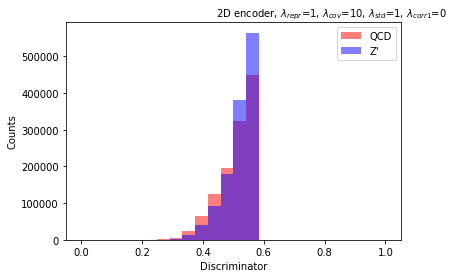

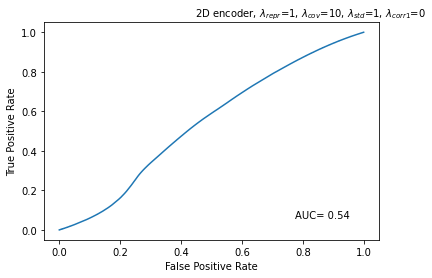

<Figure size 432x288 with 0 Axes>

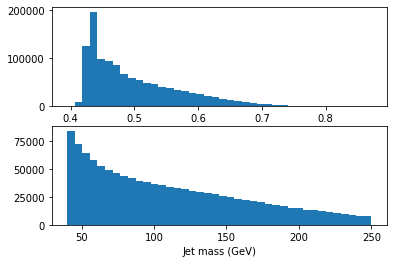

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.04632102e-05
 2.03787264e-03 3.58911172e-02 1.90402738e-01 2.95391447e-01
 3.64371291e-01 4.31420077e-01 4.95002040e-01 5.47502281e-01
 5.90628982e-01 6.30684996e-01 6.68423908e-01 7.03316694e-01
 7.36201886e-01 7.66212358e-01 7.93958713e-01 8.19752983e-01
 8.43461440e-01 8.65214448e-01 8.84937152e-01 9.02648898e-01
 9.18546491e-01 9.32658528e-01 9.45122941e-01 9.55788340e-01
 9.64953301e-01 9.727439

/uscms_data/d3/jkrupa/flat/mambaforge/envs/IN/lib/python3.10/site-packages/scipy-1.9.0-py3.10-linux-x86_64.egg/scipy/spatial/distance.py:1297: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


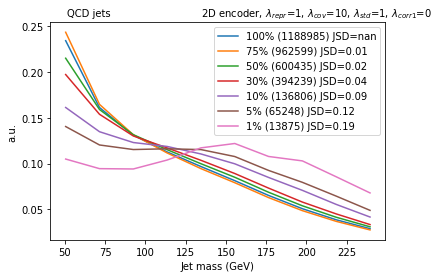

[ 0 43 47 51 59 63 69]


<Figure size 432x288 with 0 Axes>

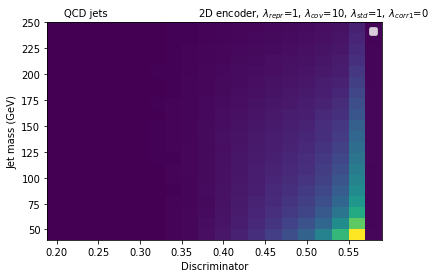

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

outputs = outputs.cpu().detach().numpy()
y_torch = y_torch.cpu().detach().numpy()
m_torch = m_torch.cpu().detach().numpy()

fig, ax=plt.subplots()
ax.hist(outputs[y_torch[:,1]==1][:,0],color="r",bins=np.linspace(0.,1.,25),alpha=0.5,label="QCD")
ax.hist(outputs[y_torch[:,1]==0][:,0],color="b",bins=np.linspace(0.,1.,25),alpha=0.5,label="Z'")
plt.legend(loc="best")
ax.set_xlabel("Discriminator")
ax.set_ylabel("Counts")
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
plt.savefig(outdir+"/discriminatorHist.png")
plt.show()

fig, ax=plt.subplots()
#print(outputs[:,0].cpu().detach().numpy(),y_torch[:,0].cpu().detach().numpy().astype(bool))
fpr, tpr, _ = roc_curve(y_torch[:,0],outputs[:,0])
ax.plot(fpr, tpr)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
ax.text(0.75,0.10, f"AUC={roc_auc_score(y_torch[:,0],outputs[:,0]) : 0.2f}", transform=ax.transAxes)
plt.savefig(outdir+"/roc.png")
plt.show()
plt.clf()

# Calculate mass distribution after cuts


hist, edges = np.histogram(outputs[y_torch[:,1]==1][:,1], bins=np.linspace(0.,1.,100),density=True)
fig,ax=plt.subplots(2,1)
ax[0].hist(outputs[y_torch[:,1]==1][:,1],bins=40)
ax[0].set_xlabel("Discriminator")
ax[1].hist(m_torch[y_torch[:,1]==1], bins=40)
ax[1].set_xlabel("Jet mass (GeV)")
plt.show()
cdf = np.cumsum(hist)*(edges[1]-edges[0])
print(cdf)

pctls = [0.,0.25,0.5,0.7,0.9,0.95,0.99]
cuts = np.searchsorted(cdf,pctls)

fig, ax=plt.subplots()

qcd_idxs = y_torch[:,1]==1
qcd_inclusive, _ = np.histogram(
        m_torch[(qcd_idxs)],
        density=True,
    )
for c,p in zip(cuts,pctls):
    passing_idxs = outputs[:,1] > edges[c]
    hist, bin_edges = np.histogram(
        m_torch[(qcd_idxs&passing_idxs)], 
    )
    N_passing = float(np.sum(hist))
    qcd_passing = np.divide(hist,[N_passing])
    jsd = scipy.spatial.distance.jensenshannon(qcd_passing, qcd_inclusive)

    bins_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    ax.plot(
        bins_centers, 
        qcd_passing,
        label = f"{(1-p)*100:.0f}% ({int(N_passing)}) JSD={0. if jsd == np.nan else jsd:.2f}"
    )
ax.set_xlabel("Jet mass (GeV)")
ax.set_ylabel("a.u.")
plt.legend(loc="best")
ax.text(0.05,1.03,"QCD jets", transform=ax.transAxes)
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
plt.savefig(outdir+"/sculptingQCD.png")
plt.show()
print(cuts)

plt.clf()
fig, ax=plt.subplots()
ax.hist2d(outputs[y_torch[:,1]==1][:,0],m_torch[y_torch[:,1]==1],bins=20)
#ax.plot(m_torch.cpu().detach().numpy(),outputs[:,1].cpu().detach().numpy(),color="b",label="Z'")
plt.legend(loc="best")
ax.set_ylabel("Jet mass (GeV)")
ax.set_xlabel("Discriminator")
ax.text(0.05,1.03,"QCD jets", transform=ax.transAxes)
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
plt.savefig(outdir+"/discriminatorvsMassQCD.png")
plt.show()

del y_torch, m_torch, outputs, outputs_optimal_clr
torch.cuda.empty_cache()

In [30]:
#os.system(f"rm {outdir}/{label}_particleTrainingData.pt")
#os.system(f"rm {outdir}/{label}_jetMassTrainingData.pt")
#os.system(f"rm {outdir}/{label}_trainingLabels.pt")